In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
import torchvision
import numpy


# Helper function to display images

In [30]:
def show_images(images, title=None):
    grid = make_grid(images, nrow=5, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# Define the Generator


In [31]:
# Generator Class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator

In [32]:
# Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


# CycleGAN training setup


In [33]:
class CycleGAN:
    def __init__(self, lr=0.0002, beta1=0.5, beta2=0.999, lambda_cycle=10):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.gen_A2B = Generator().to(device)
        self.gen_B2A = Generator().to(device)
        self.disc_A = Discriminator().to(device)
        self.disc_B = Discriminator().to(device)

        self.gen_optim = optim.Adam(
            list(self.gen_A2B.parameters()) + list(self.gen_B2A.parameters()), lr=lr, betas=(beta1, beta2)
        )
        self.disc_optim = optim.Adam(
            list(self.disc_A.parameters()) + list(self.disc_B.parameters()), lr=lr, betas=(beta1, beta2)
        )

        self.cycle_loss = nn.L1Loss().to(device)
        self.gan_loss = nn.BCELoss().to(device)
        self.lambda_cycle = lambda_cycle


# Dataset setup


In [34]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])


In [35]:
os.makedirs("trainA", exist_ok=True)
os.makedirs("trainB", exist_ok=True)


In [36]:
import os

# Get the absolute path to your dataset
trainA_path = os.path.abspath("datasets/trainA")
trainB_path = os.path.abspath("datasets/trainB")

print("TrainA Path:", trainA_path)
print("TrainB Path:", trainB_path)


TrainA Path: c:\Users\mohit\Downloads\Datasets\datasets\trainA
TrainB Path: c:\Users\mohit\Downloads\Datasets\datasets\trainB


In [37]:
import os

def verify_directory(path):
    if os.path.exists(path):
        print(f"Directory exists: {path}")
        print(f"Contents: {os.listdir(path)[:5]}")  # List first 5 items
    else:
        print(f"Directory not found: {path}")

verify_directory("trainA")
verify_directory("trainB")


Directory exists: trainA
Contents: ['class1']
Directory exists: trainB
Contents: ['class1']


In [38]:
dataset_A = datasets.ImageFolder("trainA", transform=transform)
dataset_B = datasets.ImageFolder("trainB", transform=transform)

print(f"Dataset A size: {len(dataset_A)}")
print(f"Dataset B size: {len(dataset_B)}")


Dataset A size: 1067
Dataset B size: 1334


In [39]:
dataloader_A = torch.utils.data.DataLoader(dataset_A, batch_size=1, shuffle=True)
dataloader_B = torch.utils.data.DataLoader(dataset_B, batch_size=1, shuffle=True)


In [40]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# Initialize and train CycleGAN


In [41]:
for real_A, _ in dataloader_A:
    print(real_A.shape)
    break


torch.Size([1, 3, 128, 128])


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [43]:
cyclegan = CycleGAN()
cyclegan.gen_A2B.to(device)
cyclegan.gen_B2A.to(device)
cyclegan.disc_A.to(device)
cyclegan.disc_B.to(device)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

In [44]:
real_A, _ = next(iter(dataloader_A))
real_B, _ = next(iter(dataloader_B))
real_A, real_B = real_A.to(device), real_B.to(device)
print(real_A.shape, real_B.shape)
fake_B = cyclegan.gen_A2B(real_A)
fake_A = cyclegan.gen_B2A(real_B)
print(fake_B.shape, fake_A.shape)


torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


In [45]:
epochs = 10  # Replace 10 with the desired number of epochs



In [46]:
from torch.utils.data import DataLoader

# Replace `batch_size` with the desired batch size
dataloader_A = DataLoader(dataset_A, batch_size=16, shuffle=True)
dataloader_B = DataLoader(dataset_B, batch_size=16, shuffle=True)


In [47]:
# Example
cyclegan = CycleGAN()
cyclegan.gen_A2B = cyclegan.gen_A2B.to(device)
cyclegan.gen_B2A = cyclegan.gen_B2A.to(device)


In [48]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [49]:
for real_A, _ in dataloader_A:
    print(real_A.shape)
    break

for real_B, _ in dataloader_B:
    print(real_B.shape)
    break


torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


In [50]:
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.memory_allocated())  # Check GPU memory usage


False
0


In [51]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} started.")
    for (real_A, _), (real_B, _) in zip(dataloader_A, dataloader_B):
        real_A, real_B = real_A.to(device), real_B.to(device)

        # Ensure the CycleGAN model is set up
        if hasattr(cyclegan, "gen_A2B") and hasattr(cyclegan, "gen_B2A"):
            with torch.no_grad():
                fake_B = cyclegan.gen_A2B(real_A)
                fake_A = cyclegan.gen_B2A(real_B)
        else:
            raise RuntimeError("CycleGAN generators are not properly defined.")

    print(f"Epoch {epoch+1}/{epochs} completed successfully.")


Epoch 1/10 started.
Epoch 1/10 completed successfully.
Epoch 2/10 started.
Epoch 2/10 completed successfully.
Epoch 3/10 started.
Epoch 3/10 completed successfully.
Epoch 4/10 started.
Epoch 4/10 completed successfully.
Epoch 5/10 started.
Epoch 5/10 completed successfully.
Epoch 6/10 started.
Epoch 6/10 completed successfully.
Epoch 7/10 started.
Epoch 7/10 completed successfully.
Epoch 8/10 started.
Epoch 8/10 completed successfully.
Epoch 9/10 started.
Epoch 9/10 completed successfully.
Epoch 10/10 started.
Epoch 10/10 completed successfully.


In [52]:
print(f"real_A shape: {real_A.shape}, device: {real_A.device}")
print(f"real_B shape: {real_B.shape}, device: {real_B.device}")
print(f"fake_B shape: {fake_B.shape}, device: {fake_B.device}")
print(f"fake_A shape: {fake_A.shape}, device: {fake_A.device}")


real_A shape: torch.Size([11, 3, 128, 128]), device: cpu
real_B shape: torch.Size([16, 3, 128, 128]), device: cpu
fake_B shape: torch.Size([11, 3, 128, 128]), device: cpu
fake_A shape: torch.Size([16, 3, 128, 128]), device: cpu


In [53]:
import psutil
print(f"Available Memory: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")


Available Memory: 7.01 GB


In [54]:
# Initialize and train CycleGAN
cyclegan = CycleGAN()

epochs = 10
for epoch in range(epochs):
    for real_A, real_B in zip(dataloader_A, dataloader_B):
        real_A, real_B = real_A[0].cuda(), real_B[0].cuda()
        gen_loss, disc_A_loss, disc_B_loss = cyclegan.train_step(real_A, real_B)

    print(f"Epoch {epoch+1}/{epochs} | Gen Loss: {gen_loss:.4f} | Disc A Loss: {disc_A_loss:.4f} | Disc B Loss: {disc_B_loss:.4f}")

    # Visualize progress
    fake_B = cyclegan.gen_A2B(real_A).detach()
    fake_A = cyclegan.gen_B2A(real_B).detach()
    show_images(torch.cat([real_A, fake_B, real_B, fake_A]), title="Real A -> Fake B -> Real B -> Fake A")

AssertionError: Torch not compiled with CUDA enabled

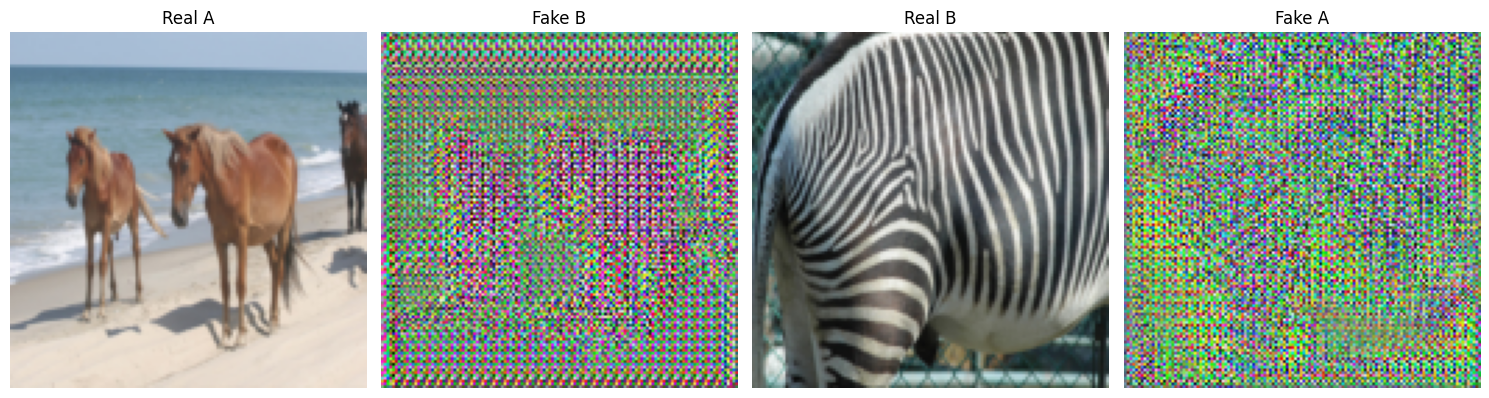

In [ ]:
small_real_A = real_A[:1]  # Only take 1 sample
small_real_B = real_B[:1]
small_fake_B = fake_B[:1]
small_fake_A = fake_A[:1]
visualize_single_image(small_real_A, small_real_B, small_fake_B, small_fake_A, index=0)